<a href="https://colab.research.google.com/github/prosyslab/sigpl23-tutorial/blob/main/1_Concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경설정하기

### 1. GPU 사용 설정
메뉴 바에서 [런타임] -> [런타임 유형 변경] -> [하드웨어 가속기] 항목에서 GPU 선택

※ Colab GPU 하루 최대 12시간까지 사용 가능


### 2. 한글 설정

주의: 아래 apt-get 설치 코드가 현재 런타임에는 바로 반영되지 않을 수 있습니다.
아래 코드 셀을 실행한 뒤 [런타임] -> [런타임 다시 시작] 을 통해 설치된 패키지가 현재 실행 환경에 반영되도록 해주세요.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

### 3. 라이브러리 설치하기
1. 현재 환경에 설치된 라이브러리 목록을 확인
2. 없는건 설치
  * torch
  * transformers
  * datasets

In [ ]:
! pip freeze

In [ ]:
! pip install transformers datasets

# 다국어 BERT (mBERT) 의 Attention 점수 확인하기


### 모델 허브에서 모델 다운로드하기
* Hugging Face model hub: https://huggingface.co/bert-base-multilingual-cased

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

### 문장 토크나이즈 해보기

In [ ]:
example_text = "가는 말이 고와야 오는 말도 곱다"
tokens = tokenizer.tokenize(example_text, add_special_tokens=True)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
for token, token_id in zip(tokens, token_ids):
  print(f"{token:>3} :: {token_id}")

[CLS] :: 101
  가 :: 8843
##는 :: 11018
  말 :: 9251
##이 :: 10739
  고 :: 8888
##와 :: 12638
##야 :: 21711
  오 :: 9580
##는 :: 11018
  말 :: 9251
##도 :: 12092
  곱 :: 8894
##다 :: 11903
[SEP] :: 102


### 모델 구조 확인
* BERT 모델 구조 사용
* 모델에 입력할수 있는 토큰 최대 길이: 512
* Embeddings Layer + 12 x Encoder Layer + Pooler Layer
  * Embeddings Layer: 119,547 -> 768
  * 12 x Encoder Layer: 768 -> 768
  * Pooler Layer: 768 -> 768

In [ ]:
print(repr(model.config))
print(repr(model))

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embe

### 모델 크기 계산해서 `pytorch_model.bin` 크기와 비교해보기

* 파라미터 개수 구하기
* 파라미터 크기 확인
  * `torch.float16` -> 개당 2 byte
  * `torch.float32` -> 개당 4 byte
* 파라미터 개수 x 파라미터 크기 = 모델의 최소 크기
  * mBERT: 178M * 4byte = 711 MB
  * `pytorch_model.bin` 크기와 거의 동일

(참고) mixed precision 사용하는 경우도 있음

In [ ]:
type_params = set([t.dtype for t in model.parameters()])
type_params

{torch.float32}

In [ ]:
num_params = sum(t.numel() for t in model.parameters())
print(f"number of params : {num_params:,}")
print(f"total param size : {num_params * 4:,}")

number of params : 177,853,440
total param size : 711,413,760


### mBERT 를 이용한 텍스트 임베딩 생성


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

# 모델과 입력 GPU 메모리에 올리기
model = model.to(device)

example_text = "가는 말이 고와야 오는 말도 곱다"
tokenized_inputs = tokenizer(example_text, return_tensors='pt')

input_ids = tokenized_inputs.input_ids.to(device)
attention_mask = tokenized_inputs.attention_mask.to(device)

# 모델 임베딩
model_out = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

### mBERT 모델의 Attention 점수 확인해보기

* 각 층별 Attention 행렬 크기: `batch_size * num_heads  * sequence_length * sequence_length`
([참고](https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutput.attentions))
* multi-head attention: attention 연산을 병렬화하는 기법
* Transformers 의 `ModelOutput` 출력에 달린 `attentions` 는 이미 multi-head attention 에 대한 softmax, weighted average 연산을 마친 값

In [ ]:
attns = model_out.attentions
len(attns), attns[0].shape

(12, torch.Size([1, 12, 15, 15]))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_attention(attention, tokens):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(tokens), :len(tokens)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + tokens, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + tokens, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

#### 마지막 레이어의 attention hitmap 출력하기

<ipython-input-14-73cbe3eccf61>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokens, fontdict=fontdict, rotation=90)
<ipython-input-14-73cbe3eccf61>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tokens, fontdict=fontdict)


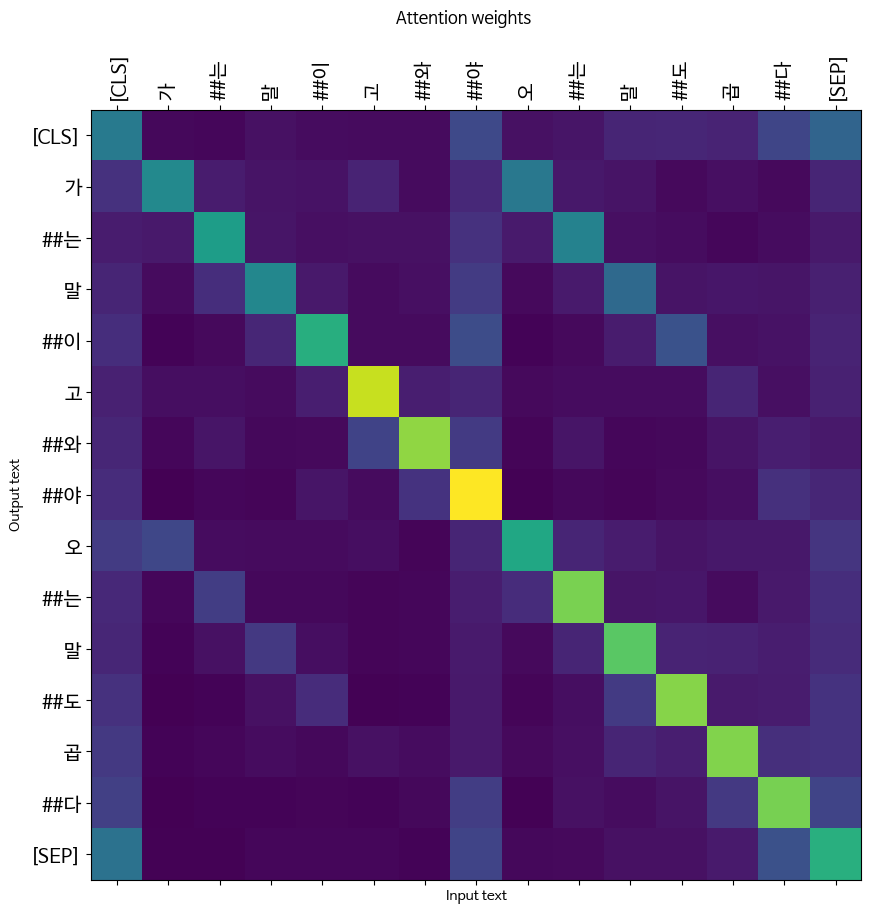

In [ ]:
layer_idx = -1
sum_heads = attns[layer_idx][0, 0, :, :]
for head_idx in range(1, model.config.num_attention_heads):
  sum_heads = sum_heads + attns[layer_idx][0, head_idx, :, :]
plot_attention(sum_heads.cpu().detach().numpy(), tokenizer.tokenize(example_text, add_special_tokens=True))